# Gravitational Wave Localizations and Galaxy Crossmatch Module

**Lecturer:** Leo Singer<br>
**Jupyter Notebook Authors:** Leo Singer, Dave Cook, Shreya Anand & Cameron Hummels

This is a Jupyter notebook lesson taken from the GROWTH Summer School 2019.  For other lessons and their accompanying lectures, please see: http://growth.caltech.edu/growth-school-2019.html
## Objective
Learn how to use LIGO/Virgo localizations and cross-match with galaxies.

## Key steps
- Manipulate HEALPix localization files
- Cross-match a LIGO localization with a galaxy catalog

## Required dependencies

The following required dependencies should be obtainable via the Google Colab, but should also be installable to your local environment using `pip install <module>` and `conda install <module>`.

### Python modules
* python 3
* astropy
* numpy
* scipy
* matplotlib
* healpy
* ligo.skymap

### External packages
None

## Imports

First, some imports: Numpy, Matplotlib, Healpy, and parts of Astropy.

In [1]:
# ! pip install healpy
import astropy.utils.data
from matplotlib import pyplot as plt
import numpy as np
import healpy as hp

Here are some extra imports for the galaxy cross matching:

In [2]:
# ! conda install -c astropy ligo.skymap 
from astropy.table import Table, vstack, hstack, Column
import astropy.units as u
from astropy.coordinates import SkyCoord
import ligo.skymap.plot
from scipy.stats import norm
import scipy.stats

And configure Matplotlib to send plot output directly to the notebook:

In [3]:
%matplotlib inline

## HEALPix Basics

This section on using HEALPix localization files is adapted from the [LIGO/Virgo Public Alerts User Guide](https://emfollow.docs.ligo.org/userguide/tutorial/skymaps.html).

### Download and read localization

Let's start by downloading a sample localization file from the User Guide. We could do this on the command line using `curl`:

    $ curl -O https://emfollow.docs.ligo.org/userguide/_static/bayestar.fits.gz

But after all, this is a Python lesson, so let's download the file using the handy `astropy.utils.data.download_file` function from Astropy.

In [4]:
url = 'https://emfollow.docs.ligo.org/userguide/_static/bayestar.fits.gz'
filename = astropy.utils.data.download_file(url)

Next, let's read in the HEALPix data using Healpy. Note that by default, Healpy only reads the first column, which provides the 2D probability distribution on the sky.

In [5]:
prob = hp.read_map(filename)

### Manipulating HEALPix Coordinates

To get a quick look at a HEALPix data set, you can use the `hp.mollview` function:

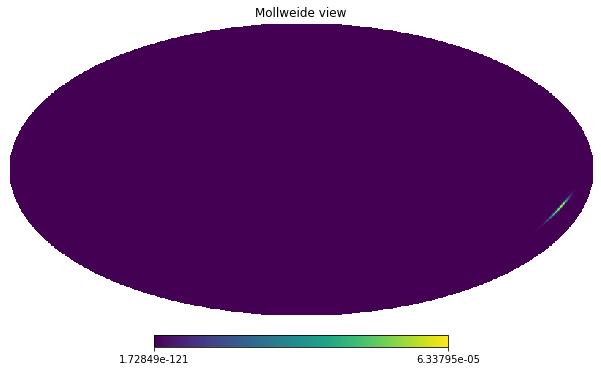

In [6]:
hp.mollview(prob)

What actually is stored in `prob`?

In [7]:
prob

array([2.70726059e-66, 1.27374324e-66, 2.62611513e-67, ...,
       2.04700874e-40, 1.05781210e-35, 4.44174764e-31])

It's a one-dimensional array! Yet it represents in 2D image. How does that work? HEALPix is a way to *index* equal-area regions on the unit sphere using integers.

To decode HEALPix indices, you need to know the resolution of the map, which is described by a parameter called `nside`. `nside` is the number of subdivisions of 12 base HEALPix tiles, so the relation between the length of a HEALPix array, `npix`, and its resolution, `nside`, is

$$
    \mathsf{npix} = 12 \cdot \mathsf{nside}^2.
$$

The functions `hp.npix2nside` and `hp.nside2npix` convert between length and resolution.

In [8]:
npix = len(prob)
npix

50331648

In [9]:
nside = hp.npix2nside(npix)
nside

2048

The function `hp.pix2ang` allow us to convert from (ra, dec) and HEALPix pixel index.

*Note*: by default, these functions return 'physics' spherical coordinates $(\theta, \phi)$ in radians, but you can switch to 'astronomy' spherical coordinates in degrees by passing the keyword argument `lonlat=True`.

Let's look up the right ascension and declination of pixel 123.

In [10]:
ipix = 123
ra, dec = hp.pix2ang(nside, ipix, lonlat=True)
ra, dec

(129.375, 89.81725848475484)

The function `hp.ang2pix` does the opposite. Let's find the pixel that contains the point RA=194.95, Dec=27.98.

In [11]:
ra = 194.95
dec = 27.98
hp.ang2pix(nside, ra, dec, lonlat=True)

13361492

What is the most probable sky location? Just find the pixel with the maximum value, and then find its right ascension and declination.

In [12]:
ipix_max = np.argmax(prob)
ipix_max

32883013

In [13]:
hp.pix2ang(nside, ipix_max, lonlat=True)

(194.30419921875, -17.856895095545468)

## Probability distributions with scipy.stats

Finding the most probable sky location within a HEALPix map involves knowing which pixels correspond to a certain probability contour (say, 90%).  We can gain insight into how these probability contours are calculated using scipy.stats.  Scipy provides a "t" distribution class that we can use to get values from the "t" statistic probability density function (PDF). As a start, we plot the PDF for a "t" statistic with 3 degrees of freedom:

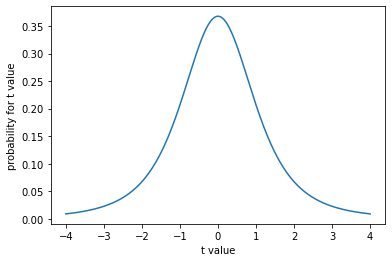

In [14]:
t_dist = scipy.stats.t(3)
t_values = np.linspace(-4, 4, 1000)
plt.plot(t_values, t_dist.pdf(t_values))
plt.xlabel('t value')
plt.ylabel('probability for t value')
plt.show()

The t distribution object t_dist can also give us the cumulative distribution function (CDF). The CDF gives the area under the curve of the PDF at and to the left of the given t value:

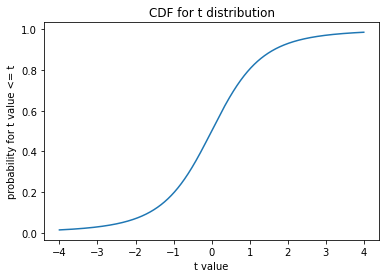

In [15]:
plt.plot(t_values, t_dist.cdf(t_values))
plt.xlabel('t value')
plt.ylabel('probability for t value <= t')
plt.title('CDF for t distribution')
plt.show()

Say I have a t value x drawn from a t distribution. The PDF gives the probability for given values of x. Because it is a probability density, the sum of the probabilities of all possible values for x: ∞<x<∞ must be 1. Therefore the total area under the PDF curve is 1, and the maximum value of the CDF is 1.

The CDF gives us the area under the PDF curve at and to the left of a given t value x. Therefore it is the probability that we will observe a value x<=t if we sample a value x from a t distribution.

Let's show relationship of PDF and CDF for three example t values.

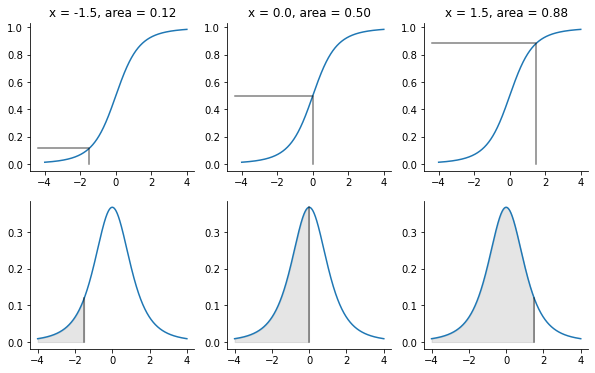

In [16]:
example_values = (-1.5, 0, 1.5)
pdf_values = t_dist.pdf(t_values)
cdf_values = t_dist.cdf(t_values)
fill_color = (0, 0, 0, 0.1)  # Light gray in RGBA format.
line_color = (0, 0, 0, 0.5)  # Medium gray in RGBA format.
fig, axes = plt.subplots(2, len(example_values), figsize=(10, 6))
for i, x in enumerate(example_values):
    cdf_ax, pdf_ax = axes[:, i]
    cdf_ax.plot(t_values, cdf_values)
    pdf_ax.plot(t_values, pdf_values)
    # Fill area at and to the left of x.
    pdf_ax.fill_between(t_values, pdf_values,
                        where=t_values <= x,
                        color=fill_color)
    pd = t_dist.pdf(x)  # Probability density at this value.
    # Line showing position of x on x-axis of PDF plot.
    pdf_ax.plot([x, x],
                [0, pd], color=line_color)
    cd = t_dist.cdf(x)  # Cumulative distribution value for this x.
    # Lines showing x and CDF value on CDF plot.
    x_ax_min = cdf_ax.axis()[0]  # x position of y axis on plot.
    cdf_ax.plot([x, x, x_ax_min],
                [0, cd, cd], color=line_color)
    cdf_ax.set_title('x = {:.1f}, area = {:.2f}'.format(x, cd))
    # Hide top and right axis lines and ticks to reduce clutter.
    for ax in (cdf_ax, pdf_ax):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

For example, say I have drawn a t value x at random from a t distribution. The probability that x<=1.5 is (i.e., >0.9253):

In [17]:
t_dist.cdf(1.5)

0.8847080673775886

The total area under the PDF is 1, and the maximum value for the CDF is 1. Therefore the area of the PDF to the right of 1.5 must be (i.e., >0.0746):

In [18]:
1 - t_dist.cdf(1.5)

0.11529193262241144

This is the probability that our t value x will be >1.5. In general, when we sample a value x at random from a t distribution, the probability that x>q is given by:

ℙ(x>q)=1−CDF(q), where CDF is the cumulative distribution function for a t value. We can apply the same methodology to HEALpix pixel probabilities in LIGO/VIRGO localization maps. 

## Working with LIGO/Virgo 3D localizations and Cross-Matching to Galaxy Catalogs

First, let's get our galaxy catalog that we will later match to the 3D localization of GW170817.

For this Section we will use a galaxy catalog from the CLU project (Census of the Local Universe; paper: https://ui.adsabs.harvard.edu/abs/2017arXiv171005016C/abstract). However, we will only use those galaxies that are publically availble and in NED (NASA/IPAC Extragalactic Database: https://ned.ipac.caltech.edu/). This catalog has already been prepared for you.

load CLU catalog into astropy table.

In [19]:
url = 'https://dcc.ligo.org/public/0146/G1701985/001/preliminary-LALInference.fits.gz'
filename = astropy.utils.data.download_file(url)

prob, distmu, distsigma, distnorm = hp.read_map(filename, field=[0, 1, 2, 3])

npix = len(prob)
nside = hp.npix2nside(npix)
pixarea = hp.nside2pixarea(nside)

In [20]:
clu=Table.read('data/CLU.hdf5')
nclu=np.size(clu)

Add probability columns to the galaxy catalog: probability density and p-value per volume and per area.

In [21]:
probdencol=Column(np.zeros(nclu,dtype='f4'),name='dP_dV')
probcol=Column(np.zeros(nclu,dtype='f4'),name='P')
probdenAcol=Column(np.zeros(nclu,dtype='f4'),name='dP_dA')
probAcol=Column(np.zeros(nclu,dtype='f4'),name='P_A')
clu.add_columns([probdencol,probcol,probdenAcol,probAcol])

Familiarize yourself with the catalog

print the columns in the catalog that will be used in the cross-match.

In [22]:
clu['name','ra','dec','distmpc','a','b2a','magb','sfr_fuv','mstar']

name,ra,dec,distmpc,a,b2a,magb,sfr_fuv,mstar
,deg,deg,Mpc,,,,,
bytes30,float64,float64,float64,float64,float64,float64,float64,float64
6dFgs gJ0001313-055904,0.38083,-5.98433,0.0556771419942379,nan,nan,25.301416397094727,nan,336.60756522868667
2MASX J00021772-4345168,0.57383,-43.75467,175.22024536132812,nan,0.416869,16.299999237060547,nan,19468772606.159004
2MASX J00022478-5445592,0.60321,-54.76653,139.5183563232422,nan,0.60256,15.859999656677246,nan,14329555096.85143
MRSS 349-063591,0.74187,-35.79772,198.0797119140625,nan,nan,nan,0.44508742359504405,19799307276.171944
2MASX J00030209-3600152,0.75863,-36.00426,198.10708618164062,nan,nan,nan,nan,25419676830.957485
IRAS F00012-5451 ID,0.948375,-54.5740833333,147.08892822265625,nan,nan,nan,nan,494003437.822152
...,...,...,...,...,...,...,...,...
CLU J121847.9+142422,184.69987120524,14.4063453816313,50.374,nan,nan,nan,nan,nan


In [23]:
# clu

'RA'=Right Ascension in degrees  <br>
'Dec'=Declination in degrees  <br>
'MODELMAG_R'=SDSS r-band magnitude  <br>
'MODELMAGERR_R'=SDSS r-band magnitude Error  <br>
'K_M_K20FE'=2MASS K-band magnitude  <br>
'K_MSIG_K20FE'=2MASS K-band magnitude Error  <br>
'W1MPRO'=WISE W1 magnitude (3.6 micron)  <br>
'W1SIGMPRO'=WISE W1 magnitude Error  <br>

### Student Exercise
Use the astropy.coordinates package and the SkyCoord function to store all of the galaxy catalog's locations. 

The astropy coordinates package provides classes for representing a variety of celestial/spatial coordinates and their velocity components, as well as tools for converting between common coordinate systems in a uniform way. In addition, the astropy coordinates package facilitates fast manipulation and cross-matching. See here for examples: https://docs.astropy.org/en/stable/coordinates/

Create a coordinate object for the entire CLU catalog (hint: use SkyCoord).

In [24]:
# YOUR CODE HERE
clu_coords = SkyCoord(clu[:]['ra'], clu[:]['dec'], frame='icrs', unit='deg')
clu_coords

<SkyCoord (ICRS): (ra, dec) in deg
    [(  0.38083   ,  -5.98433   ), (  0.57383   , -43.75467   ),
     (  0.60321   , -54.76653   ), ..., (184.69899992,  14.40244533),
     (184.67091024,  14.42045035), (183.44085718,  13.43358289)]>

In [25]:
type(clu_coords)

astropy.coordinates.sky_coordinate.SkyCoord

### GW170817 3D Localization

Now let's read in the LIGO/VIRGO HEALpix map for GW170817.

LIGO/Virgo localization files for compact binary mergers include directional estimates of distance. The distance information is stored in three additional columns. To get the distance estimates, we need to ask for all four columns: `PROB`, `DISTMU`, `DISTSIGMA`, and `DISTNORM`.

In [26]:
url = 'https://dcc.ligo.org/public/0146/G1701985/001/preliminary-LALInference.fits.gz'
filename = astropy.utils.data.download_file(url)

prob, distmu, distsigma, distnorm = hp.read_map(filename, field=[0, 1, 2, 3])

npix = len(prob)
nside = hp.npix2nside(npix)
pixarea = hp.nside2pixarea(nside)

In [27]:
# np.unique(prob)
# len(prob)
# len(distmu)
# len(distsigma)
# len(distnorm)

`PROB` - cumulative distribution function

`DISTMU` - distance location parameter (Mpc)

`DISTSIGMA` - distance scale parameter (Mpc)

`DISTNORM` - distance normalization factor (Mpc$^{-2}$)

### Student Exercise

Find the coordinates of the highest probability pixel and put the coordinates into an astropy coordinate object called 'center'

In [28]:
# YOUR CODE HERE

ipix_max = np.argmax(prob)
c_coords = hp.pix2ang(nside, ipix_max, lonlat=True)

center = SkyCoord(c_coords[0], c_coords[1], frame='icrs', unit='deg')
center

<SkyCoord (ICRS): (ra, dec) in deg
    (197.35839844, -25.61308322)>

### Other plotting packages for LIGO/VIRGO HEALPix maps.

There are many visualization packages for plotting HEALPix maps. Luckily, LIGO has taken the time to provide its own user-friendly wrapper for plotting LIGO/VIRGO localizations.

Let's plot the sky localization using an 'astroglobe' projection centered on the highest highest probability pixel and overplot this location using the ligo.skymap package. (see here: https://lscsoft.docs.ligo.org/ligo.skymap/ligo/skymap/plot/allsky.html)

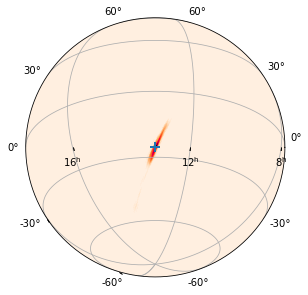

In [29]:
ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=center)

ax.grid()
ax.imshow_hpx(filename, cmap='cylon')
ax.plot(
    center.ra.deg, center.dec.deg,
    transform=ax.get_transform('world'),
    marker=ligo.skymap.plot.reticle(inner=0,outer=1),
    markersize=10,
    markeredgewidth=2)

### Student Exercises
1. Back to the galaxy catalog. Calculate the HEALPix index for each galaxy.

In [30]:
# YOUR CODE HERE
indx_galx = hp.ang2pix(nside, clu_coords[:].ra.deg, clu_coords[:].dec.deg, lonlat=True)
indx_galx[:]

array([ 6944772, 10640498, 11426197, ...,  4726837,  4722741,  4829223])

2. Compute the probabilities of each galaxy: per area, per radial distance, and per volume.

In [31]:
#probability density per area on the sky for each galaxy
dp_dA= prob[indx_galx[:]]/pixarea# YOUR CODE HERE
clu['dP_dA']=dp_dA

#probability along radial distance
dp_dr=clu['distmpc'].value**2 * distnorm[indx_galx] * norm(distmu[indx_galx],distsigma[indx_galx]).pdf(clu['distmpc'])

#probability density per volume
dp_dV= dp_dA * distnorm[indx_galx] * norm(distmu[indx_galx],distsigma[indx_galx]).pdf(clu['distmpc']) # YOUR CODE HERE
clu['dP_dV']=dp_dV

3. Use a normalized cumulative dist function to calculate P-value per area for each galaxy (hint: use np.cumsum).

In [32]:
clu.sort('dP_dA')
cumnorm_sort= np.cumsum(clu['dP_dA'].value,axis=0)/sum(clu['dP_dA'].value)
clu['P_A']=cumnorm_sort

#indices corresponding to the 90% probability contour
icutarea90= np.argwhere(cumnorm_sort > 0.9)
icutarea90= icutarea90.reshape(1,len(icutarea90))

#galaxies corresponding to 90% probability contour
clucutarea90=clu[icutarea90]

#generate astropy coordinate object for this sample
clucutarea90coord= SkyCoord(clu[icutarea90]['ra'].value, clu[icutarea90]['dec'].value, frame='icrs', unit='deg')

print('# of galaxies in 90%% Area = %i' %(np.size(icutarea90)))

#sort the galaxies by P-value and print out top 20
# YOUR CODE HERE

# of galaxies in 90% Area = 17


In [42]:
clucutarea90['name'].value

array([[b'2MASX J13060489-2351582', b'2MASX J13111030-2655596',
        b'2MASX J13132823-2713540', b'2MASS J13122568-2628206',
        b'2MASX J13124243-2721202', b'2MASX J13121969-2633515',
        b'2MASX J13123929-2642121', b'ESO 508- G 003',
        b'2MASX J13120748-2630035', b'ESO 508- G 025',
        b'GALEXASC J131215.12-264630.4', b'2MASX J13121111-2639115',
        b'2MASX J13113020-2619386', b'ESO 508- G 016',
        b'2MASX J13105449-2605323', b'2MASX J13085215-2530351',
        b'2MASX J13085466-2526013']], dtype='|S30')

### Plot the top 20 highest probability galaxies and add a zoomed-in inset.

Plot the galaxies using `plt.imshow()` on top of the GW170817 skymap `GW170817_prelim.fits.gz` located in the data directory.

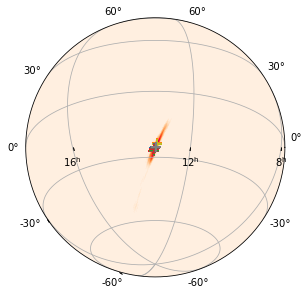

In [34]:
# YOUR CODE HERE
ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=center)

ax.grid()
ax.imshow_hpx(filename, cmap='cylon')
ax.plot(
    center.ra.deg, center.dec.deg,
    transform=ax.get_transform('world'),
    marker=ligo.skymap.plot.reticle(inner=0,outer=1),
    markersize=10,
    markeredgewidth=2)
for i in range(len(clucutarea90coord[0])):
#     print(i)
#     print(clucutarea90coord[0][i].ra.deg)
#     print('')
    ax.plot(
    clucutarea90coord[0][i].ra.deg, clucutarea90coord[0][i].dec.deg,
    transform=ax.get_transform('world'),
    marker=ligo.skymap.plot.reticle(inner=0,outer=1),
    markersize=10,
    markeredgewidth=2)


## Exercise for students - Put it all Together...

Following the examples above, find galaxies in 90% __VOLUME__ probability contour for GW170817, sort by Wise W1 luminosity, and overplot the top 20 sorted galaxies.

Information on WISE zeropoints and flux transformations
http://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html

### Part I - Find the galaxies in the 90% volumne probability

In [35]:
#load in CLU catalog
clu= 

#make astropy coordinate object of CLU galaxies
clucoord=

#sky localization colmns to the galaxy catalog: probability density and p-value per volume and per area.
probdencol=Column(np.zeros(nclu,dtype='f4'),name='dP_dV')
probcol=Column(np.zeros(nclu,dtype='f4'),name='P')
probdenAcol=Column(np.zeros(nclu,dtype='f4'),name='dP_dA')
probAcol=Column(np.zeros(nclu,dtype='f4'),name='P_A')
clu.add_columns([probdencol,probcol,probdenAcol,probAcol])

#load in healpix map and calculate npix, nside, and pixarea

#get coord of max prob density for plotting purposes and call it 'centr'
center = 

#calc hp index for each galaxy and populate CLU Table with the values
ipix=

#calc probability density per volume for each galaxy
dp_dV=
clu['dP_dV']=dp_dV

#use normalized cumulative dist function to calculate Volume P-value for each galaxy
cumnorm_sort=
clu['P']=cumnorm_sort

#ID galaxies inside the 90% prob by volume
icut90=
clucut90=clu[icut90]

#generate an astropy coordinate object for this subset
clucut90coord=

print('# of galaxies in 90%% volume = %i' %(np.size(clucut90)))



SyntaxError: invalid syntax (3336407103.py, line 2)

Q: Why are there so fewer galaxies in the volume probability?<br>
A: 

Part II - Sort by galaxy stellar mass

In [ ]:
# Sort your list by galaxy stellar mass


#then print list of prioritized galaxies


Q: Is NGC4993 in your list?<br>
A: 

### Part III - Plot up the sky localization and overplot the top 20 sorted galaxies on it.

In [ ]:
#plot up the sky localization and overplot the galaxies

#where is NGC4993? hint: use ax_inset.text()
c4993=SkyCoord.from_name('NGC 4993')
ax_inset.text()

plt.show()